<a href="https://colab.research.google.com/github/sahiser19/ST-554-Project1-Sarah_Ryan_Heather/blob/Task-2---Ryan/Task2_initial_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ST 554 Project 1: Task 2

Ryan Mersereau

This colab notebook is for conducting an extensive Exploratory Data Analysis (EDA) to understand the relationships sensor and weather
variables have with the measurement of the air pollutant Benzene (C6H6).

## Reading in Data

We'll use the air quality data found at the UCI machine learning repository, let's read it in below!

In [32]:
# Importing necessary packages
!pip install ucimlrepo
import ucimlrepo as uci
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading in data
air_quality = uci.fetch_ucirepo(id=360)
air_quality.data.features.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


This data is time series data collected from March 2004 to February 2005 in Italy, and contains measurements of pollutants and weather associated with the measurements at that time. There are several columns recording different pollutant concentrations.

Specifically, we want to investigate C6H6 as the response, which is the True hourly averaged Benze concentration in micrograms, as stated [here](https://https://archive.ics.uci.edu/dataset/360/air+quality)

Using the `.info()` method, we can get some additional information about the counts and datatypes of each variable

In [33]:
air_quality.data.features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


## Data Cleaning and Manipulation

We are told to ignore the rest of the 'true' variables, which are  gold standard measurements of pollutants in the air. These are indacted by column names ending with (GT), so let's make a new dataframe excluding these columns by subsetting the dataframe created above.

In [34]:
air_df = air_quality.data.features.drop(columns = air_quality.data.features.columns[[2, 4, 7, 9]])


We can then call this new dataframe and verify columns are dropped!

In [35]:
air_df

,Date,Time,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,1360,11.9,1046,1056,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,1292,9.4,955,1174,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,1402,9.0,939,1140,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,1376,9.2,948,1092,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1272,6.5,836,1205,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,1314,13.5,1101,539,1374,1729,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,1163,11.4,1027,604,1264,1269,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,1142,12.4,1063,603,1241,1092,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,1003,9.5,961,702,1041,770,28.3,13.5,0.5139


As stated on the dataset website, missing values are tagged with a -200 value. Therefore, we want to exclude any rows containing -200 options.

First, lets see how many -200 or missing values there are.

In [36]:
(air_df == -200).sum()

,0
Date,0
Time,0
PT08.S1(CO),366
C6H6(GT),366
PT08.S2(NMHC),366
PT08.S3(NOx),366
PT08.S4(NO2),366
PT08.S5(O3),366
T,366
RH,366


There appear to be 366 rows with missing data. Dropping these shouldn't be an issue since our original data set is over 9,000 observations.

We can do this by converting -200 cells to NaN values with `replace()`, and then using `.dropna()` to drop rows with na values. This will give us data with no missing values that will be more accurate and reliable for generating things like summary statistics.

In [37]:
air_df.replace(-200, np.nan, inplace = True)
air_df.dropna(inplace = True)
air_df

,Date,Time,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,3/10/2004,19:00:00,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,3/10/2004,20:00:00,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,3/10/2004,21:00:00,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,1314.0,13.5,1101.0,539.0,1374.0,1729.0,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,1163.0,11.4,1027.0,604.0,1264.0,1269.0,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,1142.0,12.4,1063.0,603.0,1241.0,1092.0,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,1003.0,9.5,961.0,702.0,1041.0,770.0,28.3,13.5,0.5139


Now we can get started with data analysis!

## Numerical Summaries and Variable investigation

Lets begin by finding summary statistics of our numeric variables (date and time excluded) using the `describe()` method

In [38]:
air_df.loc[:, "PT08.S1(CO)":"AH"].describe()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,1099.833166,10.083105,939.153376,835.493605,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,217.080037,7.449820,266.831429,256.817320,346.206794,398.484288,8.832116,17.316892,0.403813
min,647.000000,0.100000,383.000000,322.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,937.000000,4.400000,734.500000,658.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1063.000000,8.200000,909.000000,806.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,1231.000000,14.000000,1116.000000,969.500000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,2040.000000,63.700000,2214.000000,2683.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


This table gives us the count, mean, standard deviation, minimum, 25th quartile, 50th quartile, 75th quartile, and maximum for each variable.

We are particularly interested in our response variable, C6H6(GT), so lets dive into that deeper!

We can create a histogram to visualize the distribution of this variables observations

Text(0.5, 1.0, 'Distribution of C6H6(Benzene)')

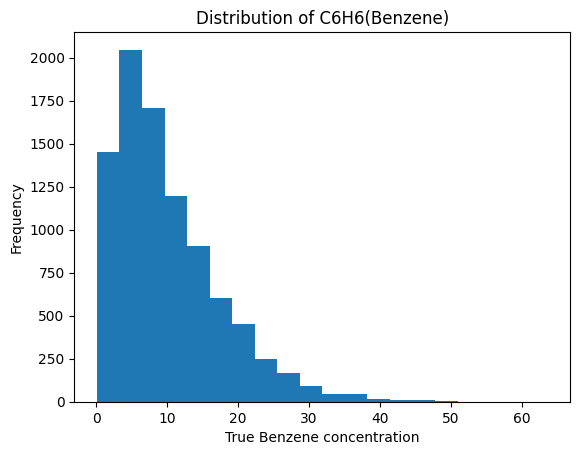

In [39]:
# Histogram of Benzene
plt.hist(air_df["C6H6(GT)"], bins = 20)
plt.xlabel("True Benzene concentration")
plt.ylabel("Frequency")
plt.title("Distribution of C6H6(Benzene)")

As we can see from the histogram, the distribution is skewed right, and does not appear to be normal (bell-shaped). This means most of the observations are concentrated around 10(micrograms), but some rare observations can be seen around 30 or 40 micrograms.

We can also illustrate this with a density plot, where y is now the proportion of total observations instead of counts (frequency)

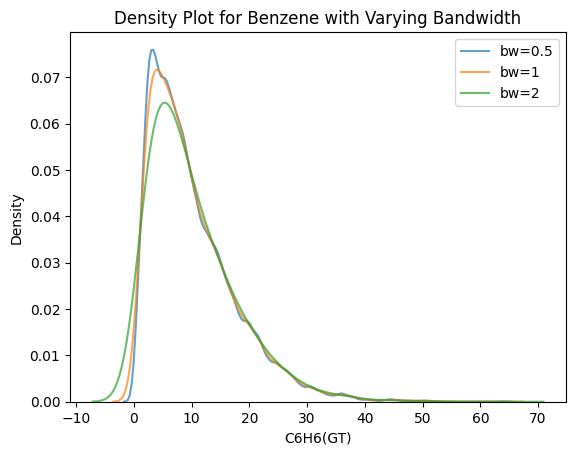

In [40]:
# Density plot for Benzene
sns.kdeplot(air_df['C6H6(GT)'], bw_adjust=0.5,alpha=0.7, label='bw=0.5')
sns.kdeplot(air_df['C6H6(GT)'], bw_adjust=1, alpha=0.7, label='bw=1')
sns.kdeplot(air_df['C6H6(GT)'], bw_adjust=2, alpha=0.7, label='bw=2')

plt.xlabel('C6H6(GT)')
plt.ylabel('Density')
plt.title('Density Plot for Benzene with Varying Bandwidth')
plt.legend()
plt.show()

Here we see a similar shape as produced by the histogram, with 3 overlayed curves representing different 'smoothness' levels of the curve.

Now, lets investigate numeric summaries of our response variable C6H6(GT) at different levels/combinations of other variables

Lets start by looking at the temperature variable (T). We can group the temperature variable into different ranges, and see if there is a difference in mean Benzene observations at different temperatures.

In [41]:
pd.cut(air_df["T"], bins = [-5, 5, 15, 25, 35, 45]).head()

,T
0,"(5, 15]"
1,"(5, 15]"
2,"(5, 15]"
3,"(5, 15]"
4,"(5, 15]"


Now, we can specify a label for each bin! Something like:

  - -5 to 5 = Very cold
  - 5 to 15 = Chilly
  - 15 to 25 = Nice
  - 25 to 35 = Hot
  - 35 to 45 = Very Hot

  These are in celsius!

In [42]:
# Saving new object temp_bin
air_df["Temp_bin"] = pd.cut(air_df["T"], bins = [-5, 5, 15, 25, 35, 45], labels = ["Very Cold", "Chilly", "Nice", "Hot", "Very Hot"])
air_df["Temp_bin"].value_counts()

,count
Temp_bin,
Nice,3397
Chilly,2996
Hot,1653
Very Cold,539
Very Hot,406


Here are the displayed counts of each temperature bin we created! For example, there are 3397 observations with 'nice' temperature, and 406 observations with 'very hot' temperature.

 Now, we can generate the mean benzene observation for each temperature range!

In [43]:
air_df.groupby("Temp_bin")["C6H6(GT)"].mean()

/tmp/ipython-input-1925404453.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  air_df.groupby("Temp_bin")["C6H6(GT)"].mean()


,C6H6(GT)
Temp_bin,
Very Cold,5.170872
Chilly,8.834379
Nice,11.010804
Hot,11.885118
Very Hot,10.720443


Interestingly, we see the mean observed benzene is significantly lower in cold weather! Going from an average of 11 micrograms for Nice weather, to 8.8 in Chilly weather, and 5.17 in Very Cold weather.

We can also represent these differences with several box plots!

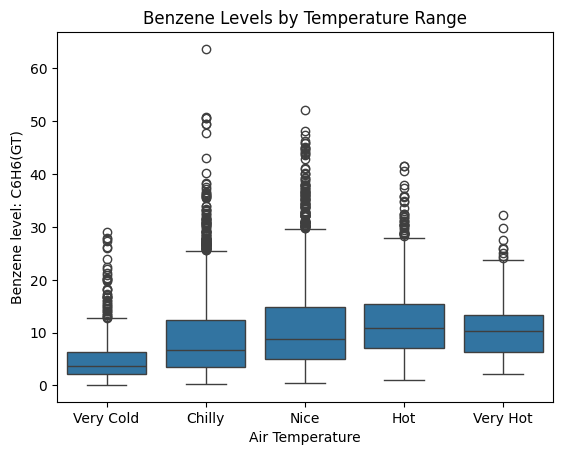

In [44]:
# Side-by-side boxplots
sns.boxplot(data=air_df, x='Temp_bin', y='C6H6(GT)', order=["Very Cold", "Chilly", "Nice", "Hot", "Very Hot"])
plt.xlabel('Air Temperature')
plt.ylabel('Benzene level: C6H6(GT)')
plt.title('Benzene Levels by Temperature Range')
plt.show()


These boxplots illustrate some significant differences in benzene levels across temperatures. The blue boxes represents the middle 50% of data, and the horizontal lines inside the blue box are the means for each temperature range. The circles above each box plot represent several outliers, which is interesting there are so many.

From, we can confirm that the mean benzene levels during very cold temperatures appear to be lower than other temperature ranges. Additionally, the minimum, Inter-quartile range, and maximum are also lower in the 'Very cold' group

Lets do something similar one more time by looking at levels of sensor readings compared to the actual observed benzene level. For example, lets look at the first sensor "PT08.S1", which senses for atmosphering CO (Cobalt) levels.

First we'll look at a histogram of the sensor data:




Text(0.5, 1.0, 'Distribution of observed atmospheric cobalt')

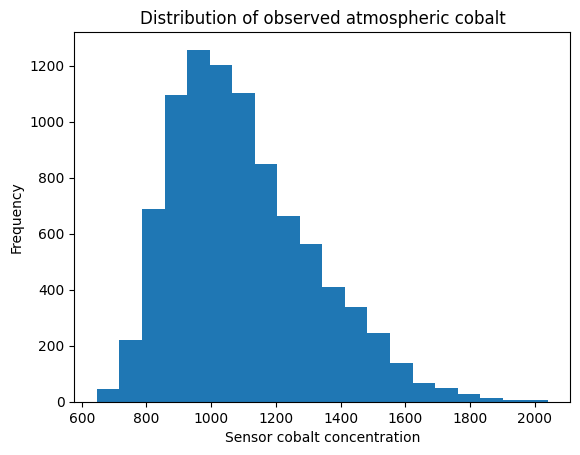

In [45]:
# Histogram of Cobat sensor data
plt.hist(air_df["PT08.S1(CO)"], bins = 20)
plt.xlabel("Sensor cobalt concentration")
plt.ylabel("Frequency")
plt.title("Distribution of observed atmospheric cobalt")

We can see from this histogram that the cobat concentrations are also slightly right skewed, and range from around 600 to 2000

Based on this, lets create some ranges for cobalt concentration and save them to a new variable:

In [46]:
air_df["Cobalt_bin"] = pd.cut(air_df["PT08.S1(CO)"], bins = [600, 900, 1200, 1500, 2100], labels = ["Low", "Moderate", "High", "Very High"])

Now, we can create more boxplots in a similar manner to investigate the relationship between sensor readings for cobalt and true atmospheric benzene levels!

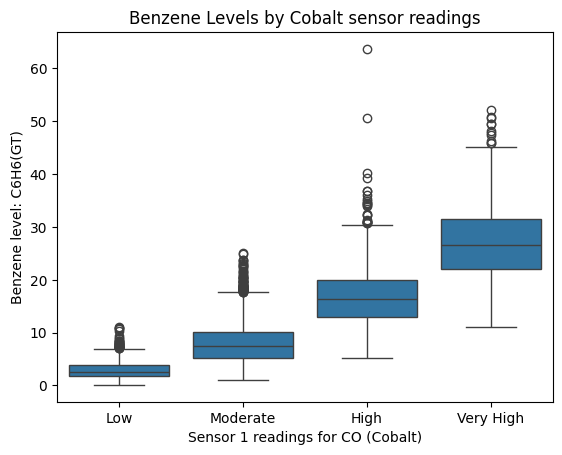

In [47]:
# Side-by-side boxplots
sns.boxplot(data=air_df, x='Cobalt_bin', y='C6H6(GT)', order=["Low", "Moderate", "High", "Very High"])
plt.xlabel('Sensor 1 readings for CO (Cobalt)')
plt.ylabel('Benzene level: C6H6(GT)')
plt.title('Benzene Levels by Cobalt sensor readings')
plt.show()

Here we have some clear evidence of differences in benzene measurements based on the first sensor reading for cobalt. If the sensor reading is 'low", benzene levels average less than 5 micrograms. However, if the sensor reading is "very high", benzene levels average around 25 micrograms! There are several outliers, but this first sensor appears to be a good indication of true atmospheric benzene levels.

## Correlation Investigation

Now, lets look at correlations between variables. That is, a quantitative measure of the linear relationship between two variables.

In [48]:
# Correlation matrix between all numeric variables
air_df[["PT08.S1(CO)", "C6H6(GT)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "RH", "AH"]].corr()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
PT08.S1(CO),1.000000,0.883795,0.892964,-0.771938,0.682881,0.899324,0.048627,0.114606,0.135324
C6H6(GT),0.883795,1.000000,0.981950,-0.735744,0.765731,0.865689,0.198956,-0.061681,0.167972
PT08.S2(NMHC),0.892964,0.981950,1.000000,-0.796703,0.777254,0.880578,0.241373,-0.090380,0.186933
PT08.S3(NOx),-0.771938,-0.735744,-0.796703,1.000000,-0.538468,-0.796569,-0.145112,-0.056740,-0.232017
PT08.S4(NO2),0.682881,0.765731,0.777254,-0.538468,1.000000,0.591144,0.561270,-0.032188,0.629641
PT08.S5(O3),0.899324,0.865689,0.880578,-0.796569,0.591144,1.000000,-0.027172,0.124956,0.070751
T,0.048627,0.198956,0.241373,-0.145112,0.561270,-0.027172,1.000000,-0.578621,0.656397
RH,0.114606,-0.061681,-0.090380,-0.056740,-0.032188,0.124956,-0.578621,1.000000,0.167971
AH,0.135324,0.167972,0.186933,-0.232017,0.629641,0.070751,0.656397,0.167971,1.000000


This correlation matrix shows the linear relationship for all combinations of variables! Correlation, also known as r, is measured on a scale from -1 to 1. For example, a value near 1 represents a strong, positive linear association between the two variables. A value near -1 represents a strong, negative linear association. A value near 0 represents little to no association, and a value of 0.3-0.4 may be a weak or non-linear, positive association.

Now, lets generate some scatterplots to investigate these correlations further

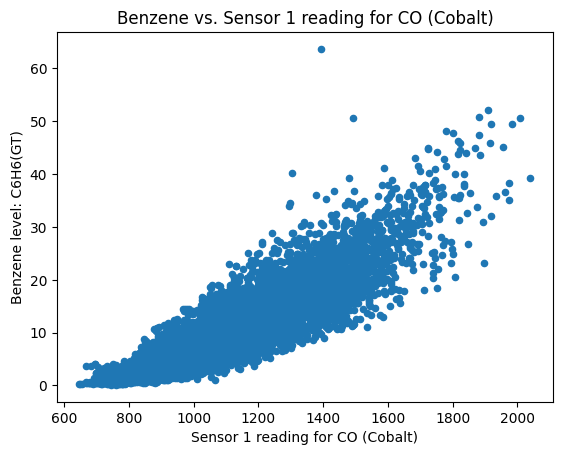

In [59]:
# Scatterplot between PT08.S1(CO) and C6H6(GT)
air_df.plot.scatter(x = "PT08.S1(CO)", y = "C6H6(GT)")
plt.xlabel("Sensor 1 reading for CO (Cobalt)")
plt.ylabel("Benzene level: C6H6(GT)")
plt.title("Benzene vs. Sensor 1 reading for CO (Cobalt)")
plt.show()

# For scatterplots, add regression line of best fit, display equation and r/r^2 values

This is a scatterplot between our first sensor variable and the response variable benzene, which we investigated above. These variables have a correlation of r = 0.883, which as we can see is a strong, linear association. As one variable rises, the other tends to rise as well. However, there could be some issues with large/ non-constant variance.


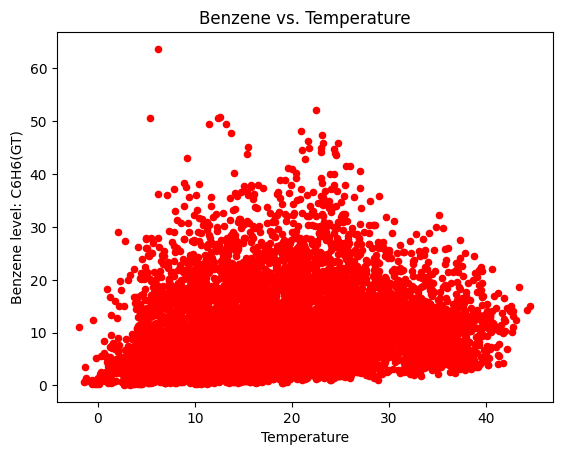

In [60]:
# Scatterplot between T and C6H6
air_df.plot.scatter(x = "T", y = "C6H6(GT)", c = "Red")
plt.xlabel("Temperature")
plt.ylabel("Benzene level: C6H6(GT)")
plt.title("Benzene vs. Temperature")
plt.show()


Above is a scatterplot of benzene vs temperature, which has a correlation r = 0.19. From this value and the scatterplot, there isn't a strong relationship between these two variables.

Text(0.5, 1.0, 'Benze vs Sensor 2 reading for NMHC')

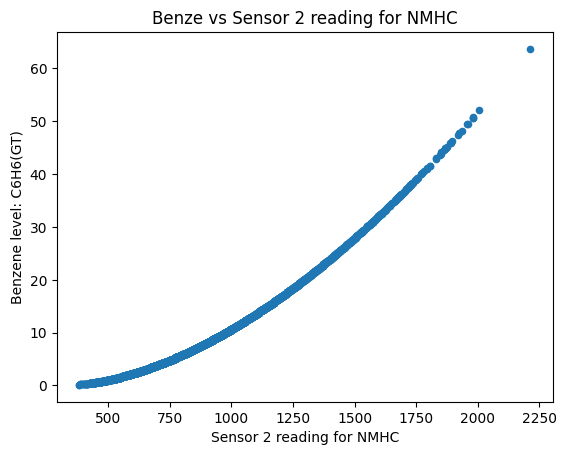

In [61]:
# Scatterplot between PT08.S2(NMHC) and C6H6
air_df.plot.scatter(x ="PT08.S2(NMHC)", y = "C6H6(GT)")
plt.ylabel("Benzene level: C6H6(GT)")
plt.xlabel("Sensor 2 reading for NMHC")
plt.title("Benze vs Sensor 2 reading for NMHC")

This is the scatterplot between sensor 2 and our response, benzene. These two variables are very strongly correlated, with r = 0.98. However, from the curve in the scatterplot, the relationship might be modeled better by a quadratic equation.

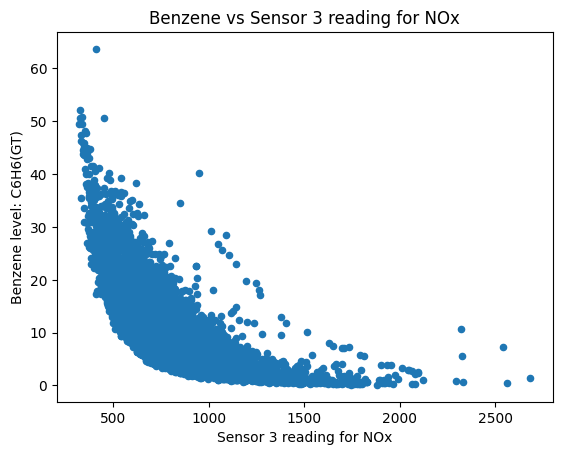

In [62]:
# Scatterplot between PT08.S3(NOx) and C6H6
air_df.plot.scatter(x = "PT08.S3(NOx)", y = "C6H6(GT)")
plt.ylabel("Benzene level: C6H6(GT)")
plt.xlabel("Sensor 3 reading for NOx")
plt.title("Benzene vs Sensor 3 reading for NOx")
plt.show()

Finally, heres one more scatterplot between sensor 3 readings and benzene measurement. These variables have a correlation coefficient of r = -0.73, fairly strong negative relationship. The scatterplot of this data also shows some evidence of non-linearity from the downwarding sloping curve.

## Trends over time

Now, since this is time series data over the course of a year, lets investigate how our response variable fluctuates over time!

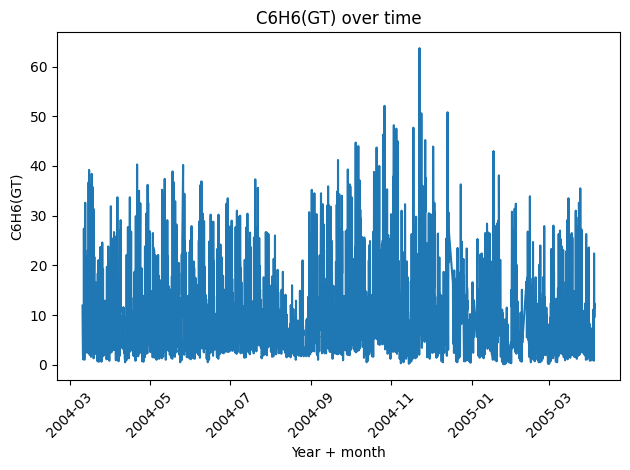

In [53]:
# Plot of all benzene observations over time
air_df["Datetime"] = pd.to_datetime(air_df["Date"].astype(str) + " " + air_df["Time"].astype(str), format = "%m/%d/%Y %H:%M:%S")
plt.plot(air_df["Datetime"], air_df["C6H6(GT)"])
plt.xlabel("Year + month")
plt.ylabel("C6H6(GT)")
plt.title("C6H6(GT) over time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Should investigate mean benzene levels over time

This line graph of all observations of benzene over time is very messy, but it tells us some useful information! Because there are so many tightly packed spikes, we know that benzene levels fluctuate by large amounts over time. Perhaps having large changes by day or even by hour, so lets investigate that further!

Above, we created a Datetime column by combining the date and time variables into one timestamp. Now, lets group observations by hour using `.dt`

In [55]:
# C6H6(GT) by hour
air_df["Hour"] = air_df["Datetime"].dt.hour
hourly_mean = air_df.groupby("Hour")["C6H6(GT)"].mean()
print(hourly_mean)

Hour
0      7.684140
1      5.991711
2      4.379467
3      3.379255
4      2.916711
5      3.068435
6      4.756117
7     10.398936
8     15.894149
9     14.760317
10    12.237666
11    11.018085
12    10.824138
13    10.980637
14    10.316310
15    10.267914
16    11.118499
17    13.942857
18    16.639678
19    17.735580
20    15.384450
21    11.089008
22     8.977748
23     8.412634
Name: C6H6(GT), dtype: float64


By looking at mean atmospheric benzene by hour, we can see a significant drop in Benzene levels overnight compared to during the day.

In [56]:
air_df.groupby("Hour")["C6H6(GT)"].std()

,C6H6(GT)
Hour,
0,3.921664
1,3.170991
2,2.561266
3,2.228278
4,1.991421
5,1.935430
6,2.768897
7,7.823343
8,9.829296


The standard deviation during the day also appears much higher than at night

Let's plot this to clearly see the hourly change!

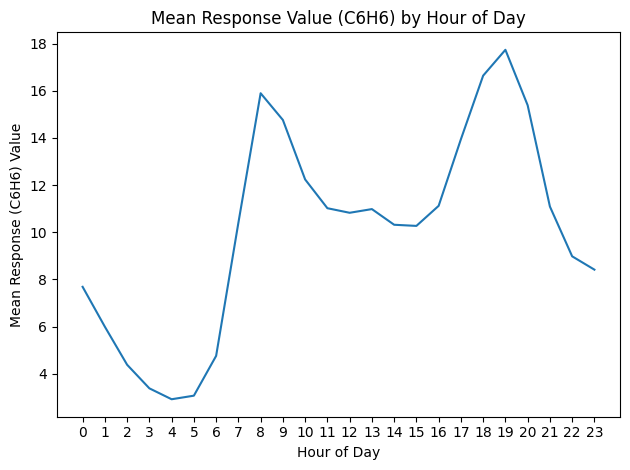

In [57]:
plt.plot(hourly_mean.index, hourly_mean.values)
plt.xlabel('Hour of Day')
plt.ylabel('Mean Response (C6H6) Value')
plt.title('Mean Response Value (C6H6) by Hour of Day')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

From this line graph, we can clearly see how benzene concentrations change throughout the day within this city, on average.

This data is taken from a populated city in Italy, so the spikes at around 9 AM and 1800 (7 PM) could be commuter traffic generating pollutatants. The hours of 11 PM to 6 AM see a large dim in true benzene levels, on average, which could be due to less people, vehicles, factories, and such producing pollutants during these hours.

We can't say for sure, that would require formal hypothesis testing, but now we have several avenues to explore deeper in this dataset!